In [1]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import product

import scipy.spatial

import pyclustering
from pyclustering.cluster.kmeans import kmeans as pyKMeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


import clustering_utils

In [2]:
df_weather = pd.read_csv('data/weather.csv', index_col=0)
df_region_ids = pd.read_csv('data/regions.csv')

In [3]:
df_weather.head()

,date,weather,weather_l,region_ids,region_names,conditions_ids,conditions
0,2019-04-07 11:45:00,8 апреля в горах Дагестана выше 2500 м в гора...,8 апрель в гора дагестан высоко 2500 м в гора ...,"[43, 46]","['Республика Алтай', 'Республика Дагестан']",[6],['лавины']
1,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...,14 - 15 февраль в сыктывкар ожидаться аномальн...,[50],['Республика Коми'],[],[]
2,2019-04-06 10:55:00,7-9 апреля в горных районах муниципального обр...,7 - 9 апрель в горный район муниципальный обра...,[22],['Краснодарский край'],[6],['лавины']
3,2024-02-12 15:18:00,14-15 февраля в Сыктывкаре ожидается аномально...,14 - 15 февраль в сыктывкар ожидаться аномальн...,[50],['Республика Коми'],[],[]
4,2019-04-06 09:30:00,7 апреля в горах Дагестана выше 2500 м 7-9 ...,7 апрель в гора дагестан высоко 2500 м 7 - 9 а...,"[42, 77, 46, 47, 22]","['Республика Адыгея', 'Чеченская Республика', ...",[6],['лавины']


In [4]:
from ast import literal_eval

In [5]:
df_weather = df_weather[['date', 'region_ids', 'conditions_ids']]
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather['region_ids'] = df_weather['region_ids'].apply(literal_eval)
df_weather['conditions_ids'] = df_weather['conditions_ids'].apply(literal_eval)
df_weather.head()

,date,region_ids,conditions_ids
0,2019-04-07 11:45:00,"[43, 46]",[6]
1,2024-02-12 15:18:00,[50],[]
2,2019-04-06 10:55:00,[22],[6]
3,2024-02-12 15:18:00,[50],[]
4,2019-04-06 09:30:00,"[42, 77, 46, 47, 22]",[6]


In [6]:
df_weather = df_weather[df_weather['conditions_ids'].apply(lambda x : len(x) > 0)]

In [7]:
df_weather.head()

,date,region_ids,conditions_ids
0,2019-04-07 11:45:00,"[43, 46]",[6]
2,2019-04-06 10:55:00,[22],[6]
4,2019-04-06 09:30:00,"[42, 77, 46, 47, 22]",[6]
5,2024-02-12 14:25:00,[61],"[10, 5]"
6,2019-04-05 13:03:00,[22],[7]


In [8]:
df_weather['month'] = df_weather['date'].dt.month
df_weather.drop('date', axis=1, inplace=True)
df_weather.head()

,region_ids,conditions_ids,month
0,"[43, 46]",[6],4
2,[22],[6],4
4,"[42, 77, 46, 47, 22]",[6],4
5,[61],"[10, 5]",2
6,[22],[7],4


In [9]:
df_weather = df_weather.explode('region_ids', ignore_index=True)
df_weather = df_weather.explode('conditions_ids', ignore_index=True)

In [10]:
print(len(df_weather))
df_weather.dropna(inplace=True)
print(len(df_weather))
df_weather.head()

38264
37930


,region_ids,conditions_ids,month
0,43,6,4
1,46,6,4
2,22,6,4
3,42,6,4
4,77,6,4


In [14]:
weather_ids = pd.read_csv('data/weather_ids.csv', index_col=0, header=None).squeeze()
weather_ids

0
1                                ветер
2                         дожди, ливни
3                                гроза
4                                 град
5             снегопад, снежный покров
6                               лавины
7                            заморозки
8                               метель
9     паводки, подтопления, наводнения
10                   гололед, изморозь
11                                жара
12                               мороз
13                                сель
14           туман, снижение видимости
15                              ураган
16                               смерч
17                        пылевая буря
18            вулканическая активность
Name: 1, dtype: object

In [15]:
cond_count = len(weather_ids)
month_cond_labels = [str(i) + '_' + str(j) for (i, j) in product(range(1, 13), range(1, cond_count + 1))]

In [16]:
df_regions1 = pd.DataFrame(columns=['region_id'] + month_cond_labels)

In [17]:
print(cond_count * 12)
df_regions1.head()

216


,region_id,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,...,12_9,12_10,12_11,12_12,12_13,12_14,12_15,12_16,12_17,12_18


In [18]:
regions_dict1 = {region : {s : 0 for s in month_cond_labels} for region in df_region_ids.index}

In [19]:
sorted(df_weather['conditions_ids'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [20]:
for index, row in df_weather.iterrows() :
    s = str(row['month']) + '_' + str(row['conditions_ids'])
    regions_dict1[row['region_ids']][s] += 1

In [21]:
df_regions1 = pd.DataFrame.from_dict(regions_dict1, orient='index')

In [22]:
df_regions1.head()

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,...,12_9,12_10,12_11,12_12,12_13,12_14,12_15,12_16,12_17,12_18
0,18,3,0,0,18,0,3,18,0,17,...,0,26,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,6,...,0,1,0,0,0,0,0,0,0,0
2,2,0,0,0,2,0,0,2,0,0,...,0,1,0,5,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
4,2,0,0,0,3,0,0,2,0,2,...,0,3,0,0,0,0,0,0,0,0


In [23]:
df_regions1 = df_regions1.astype(float)

In [24]:
df_regions1.iloc[33] *= 0.3

In [25]:
X = df_regions1.copy()
X.head()

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,...,12_9,12_10,12_11,12_12,12_13,12_14,12_15,12_16,12_17,12_18
0,18.0,3.0,0.0,0.0,18.0,0.0,3.0,18.0,0.0,17.0,...,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
N = len(df_regions1)
d_mean = np.zeros(len(weather_ids))
d_mean_m = np.zeros(len(weather_ids))
for j in range(len(weather_ids)) :
    d_temp = 0
    d_temp_m = 0
    for i1, i2 in product(range(N), range(N)) :
        for m in range(12) :
            d_temp += (df_regions1.iloc[i1, m * len(weather_ids) + j] - df_regions1.iloc[i2, m * len(weather_ids) + j])**2
            d_temp_m += (df_regions1.iloc[i1, m * len(weather_ids) + j] - df_regions1.iloc[i2, m * len(weather_ids) + j])
    d_mean[j] = ((d_temp / N**2) + 0.01)
    d_mean_m[j] = ((d_temp_m / N**2) + 0.01)

In [27]:
d_mean_full = np.zeros(len(weather_ids) * 12)
d_mean_full_m = np.zeros(len(weather_ids) * 12)
for j in range(len(weather_ids) * 12) :
    d_temp = 0
    d_temp_m = 0
    for i1, i2, in product(range(N), range(N)) :
        d_temp += (df_regions1.iloc[i1, j] - df_regions1.iloc[i2, j])**2
        d_temp_m += (df_regions1.iloc[i1, j] - df_regions1.iloc[i2, j])
    d_mean_full[j] = (d_temp / N**2) + 0.01
    d_mean_full_m[j] = (d_temp_m / N**2) + 0.01

In [28]:
w = np.array([(1.0) / (d_mean[i % (12)]) for i in range(12 * len(d_mean))])
w_m = np.array([(1.0) / (d_mean_m[i % 12]) for i in range(12 * len(d_mean))])
w /= np.sum(w)
w_m /= np.sum(w_m)

In [29]:
w_full = np.array([(1.0) / d for d in d_mean_full])
w_full_m = np.array([(1.0) / d for d in d_mean_full_m])
w_full /= np.sum(w_full)
w_full_m /= np.sum(w_full_m)

In [30]:
temp = [100, 100, 100, 100, 100, 1, 100, 2, 100, 100, 1, 1, 2, 100, 1, 1, 1, 1]
w_custom = np.array([(1.0) / (temp[i % len(temp)]) for i in range(12 * len(d_mean))])
w_custom /= np.sum(w_custom)

In [31]:
weather_ids

0
1                                ветер
2                         дожди, ливни
3                                гроза
4                                 град
5             снегопад, снежный покров
6                               лавины
7                            заморозки
8                               метель
9     паводки, подтопления, наводнения
10                   гололед, изморозь
11                                жара
12                               мороз
13                                сель
14           туман, снижение видимости
15                              ураган
16                               смерч
17                        пылевая буря
18            вулканическая активность
Name: 1, dtype: object

In [32]:
weights = w_custom

In [33]:
euclidian_weightned_distance = lambda x, y : scipy.spatial.distance.euclidean(x, y, weights)

In [34]:
manhattan_weightned_distance = lambda x, y : scipy.spatial.distance.cityblock(x, y, weights)

In [35]:
cosine_weightned_distance = lambda x, y : scipy.spatial.distance.cosine(x, y, weights)

In [188]:
#custom_distance = lambda x, y : scipy.spatial.distance.euclidean(x, y)
custom_distance = cosine_weightned_distance

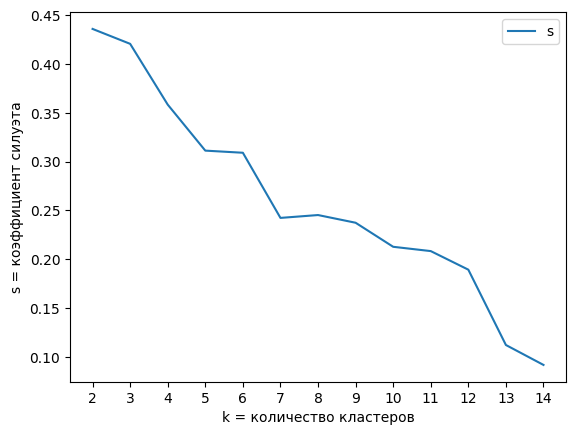

In [189]:
clustering_utils.silhouette_criteria((X), clustering_func=clustering_utils.KMeans, custom_distance=custom_distance)
plt.legend(('s(k) - silhouette coef'))
plt.ylabel('s = коэффициент силуэта')
plt.show()

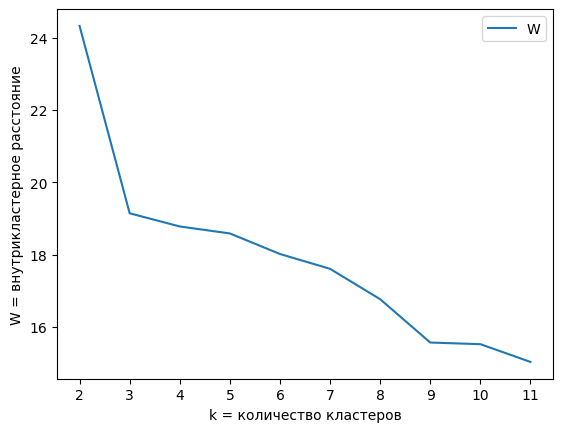

In [190]:
clustering_utils.elbow_criteria(X, clustering_func=clustering_utils.KMeans, custom_distance=custom_distance)
plt.ylabel('W = внутрикластерное расстояние')
plt.legend('W')

In [191]:
#kmeans = KMeans(n_clusters=2).fit_predict((X))
kmeans = clustering_utils.KMeans((X), custom_distance, n_clusters = 4)

In [192]:
df_regions_clustered = df_regions1.copy()
df_regions_clustered['cluster_id'] = kmeans[0]
df_regions_clustered['region_name'] = df_region_ids['region']
# for i in range(len(df_regions1)) :
#     df_regions1['region_name'][i] = df_region_ids[i]
df_regions_clustered.head()

,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,...,12_11,12_12,12_13,12_14,12_15,12_16,12_17,12_18,cluster_id,region_name
0,18.0,3.0,0.0,0.0,18.0,0.0,3.0,18.0,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Алтайский край
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Амурская область
2,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Архангельская область
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Астраханская область
4,2.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,Белгородская область


In [193]:
df_regions_clustered.to_csv('regions1.csv')

In [194]:
labels = df_regions_clustered['cluster_id']

In [195]:
sil_score = silhouette_score((X), labels, metric=custom_distance)
sil_score

0.35832657037180865

In [196]:
dbscan = DBSCAN(metric=euclidian_weightned_distance).fit(X)

In [247]:
df_regions_clustered_temp = df_regions_clustered[df_regions_clustered['cluster_id'] == 0].drop(['cluster_id', 'region_name'], axis=1)

In [248]:
df_weather_clusters = df_weather.copy()
df_weather_clusters['cluster_id'] = [np.nan] * len(df_weather_clusters)
df_weather_clusters['condition_name'] = [weather_ids[i] for i in df_weather_clusters['conditions_ids']]
df_weather_clusters['condition_name'] = pd.Categorical(df_weather_clusters['condition_name'], list(df_weather_clusters['condition_name'].unique()))

In [249]:
for i in range(len(df_weather_clusters)) :
    r = df_regions_clustered.iloc[df_weather_clusters.iloc[i]['region_ids']]['cluster_id']
    df_weather_clusters.at[i, 'cluster_id'] = r
    #print(df_regions_clustered.iloc[i]['cluster_id'])

In [250]:
df_weather_clusters.head()

,region_ids,conditions_ids,month,cluster_id,condition_name
0,43,6,4.0,1.0,лавины
1,46,6,4.0,2.0,лавины
2,22,6,4.0,1.0,лавины
3,42,6,4.0,2.0,лавины
4,77,6,4.0,2.0,лавины


In [251]:
stop_list = ['гололед, изморозь', "снегопад, снежный покров", "заморозки", "ветер", "дожди, ливни", "гроза", "паводки, подтопления, наводнения", "град", "лавины"]

In [252]:
interesting = ['мороз', 'лавины', 'сель', 'вулканическая активность', 'пылевая буря', 'ураган', 'смерч']

In [264]:
df_weather_clusters1 = df_weather_clusters[df_weather_clusters['condition_name'].isin(interesting)].dropna()

In [271]:
df_weather_clusters1['condition_name'] = pd.Categorical(df_weather_clusters1['condition_name'], 
                                                        categories=['лавины', 'сель', 
                                                                            "вулканическая активность", 
                                                                            "мороз", "пылевая буря",
                                                                            "ураган", "смерч"])

In [295]:
def get_smth(i) :
    return df_weather_clusters[df_weather_clusters['cluster_id'] == i]['conditions_ids']

(0.0, 0.2)

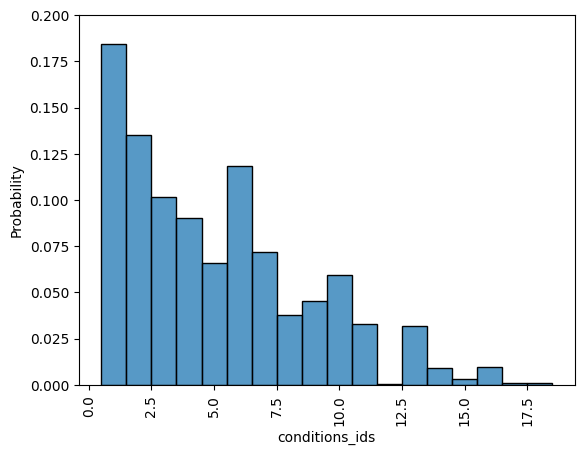

In [296]:
sns.histplot(get_smth(float(0)), stat='probability', discrete=True)
plt.xticks(rotation=90)
plt.ylim(0, 0.2)

(0.0, 0.2)

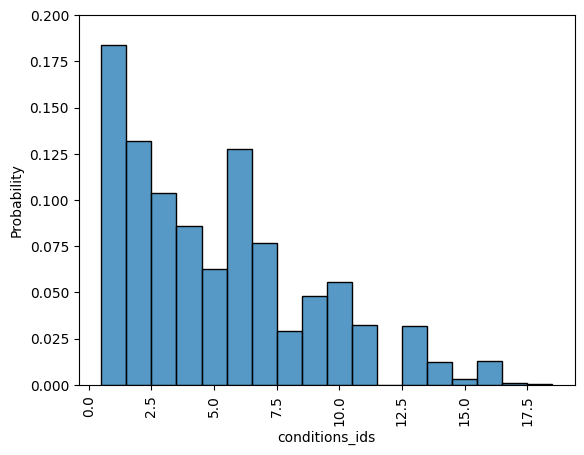

In [297]:
sns.histplot(get_smth(float(1)), discrete=True, stat='probability')
plt.xticks(rotation=90)
plt.ylim(0, 0.2)

(0.0, 0.2)

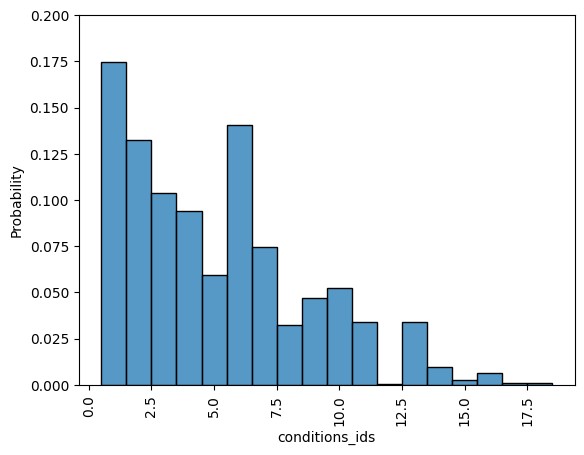

In [298]:
sns.histplot(get_smth(float(2)), discrete=True, stat='probability')
plt.xticks(rotation=90)
plt.ylim(0, 0.2)

(0.0, 0.2)

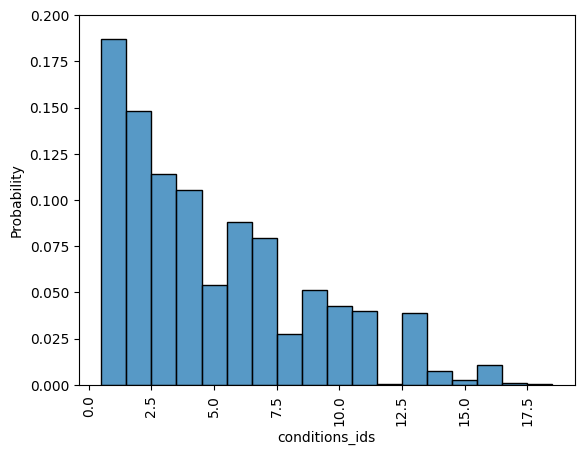

In [299]:
sns.histplot(get_smth(float(3)), discrete=True, stat='probability')
plt.xticks(rotation=90)
plt.ylim(0, 0.2)